In [35]:
import sys
from pathlib import Path

current_dir = Path().resolve()
parent_dir = current_dir.parent
sys.path.insert(0, str(parent_dir))

from KalmanFilterSV import MeasurementType, HestonKalmanFilter
from model.Heston import *
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set initial conditions and simulation parameters
S0 = 100
V0 = 0.04
params = {
    'mu': 0.05,
    'rho': -0.8,
    'kappa': 0.8,
    'theta': 0.04,
    'xi': 0.2
}
std_asy = np.sqrt(params['theta'] * params['xi']**2 / (2 * params['kappa']))
assert 2 * params['kappa'] * params['theta'] > params['xi']**2, "Feller condition is violated!"

Hest = Heston(**params)
time_daily, S_daily, daily_returns, daily_true_V, daily_RV = Hest.path_simulation(
    S0, V0, T_years=10, trading_days=252, intraday_intervals=39, seed=100
)
R_daily = daily_returns.copy()

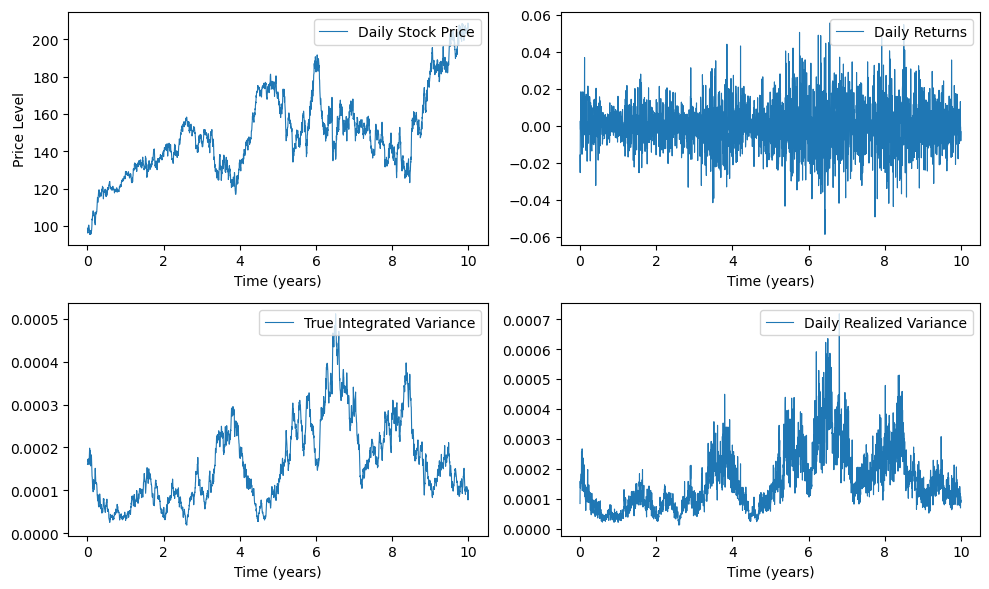

In [36]:
fig, axes = plt.subplots(2, 2, figsize=(10, 6))

# Subplot for BOTH measurements
axes[0,0].plot(time_daily, S_daily, label="Daily Stock Price", lw=0.8)
axes[0,0].set_xlabel("Time (years)")
axes[0,0].set_ylabel("Price Level")
axes[0,0].legend(loc="upper right")

# Subplot for RETURNS measurement
axes[0,1].plot(time_daily, daily_returns, label="Daily Returns", lw=0.8)
axes[0,1].set_xlabel("Time (years)")
axes[0,1].legend(loc="upper right")

# Subplot for RV measurement
axes[1,0].plot(time_daily, daily_true_V, label="True Integrated Variance", lw=0.8)
axes[1,0].set_xlabel("Time (years)")
axes[1,0].legend(loc="upper right")

# Subplot for RV measurement
axes[1,1].plot(time_daily, daily_RV, label="Daily Realized Variance", lw=0.8)
axes[1,1].set_xlabel("Time (years)")
axes[1,1].legend(loc="upper right")

plt.tight_layout()
plt.show()

In [37]:
burnin = 500
dt = 1  # Daily

# ============================================================================
# 1. BOTH Measurements: Uses both returns and RV
# ============================================================================

# Instantiate the Kalman filter for BOTH measurement type.
hkf_both = HestonKalmanFilter(measurement_type=MeasurementType.BOTH, dt=dt, V0=0.01, P0=0.1)
# Set the full data: filtering will be computed over all observations.
hkf_both.set_data(returns=R_daily, rv=daily_RV)
# For BOTH, parameter order is: [kappa, theta, xi, mu, sigma]
initial_params_both = np.array([0.001, 0.001, 0.001, 0.001, 0.001])
# Fit the model using the burnin (likelihood uses only t ≥ burnin).
fit_results_both = hkf_both.fit(initial_params=initial_params_both, burnin=burnin)
params_opt_both = fit_results_both['params']
print("Optimized parameters (BOTH):", params_opt_both)
# Retrieve filtered variance.
V_filt_both = hkf_both.get_filtered_variance()

# ============================================================================
# 2. RETURNS Measurement: Uses only returns data
# ============================================================================

hkf_returns = HestonKalmanFilter(measurement_type=MeasurementType.RETURNS, dt=dt, V0=0.01, P0=0.1)
# For returns-only, only return data is needed.
hkf_returns.set_data(returns=R_daily)
# Parameter order for RETURNS is: [kappa, theta, xi, mu]
initial_params_returns = np.array([0.001, 0.001, 0.001, 0.001])
fit_results_returns = hkf_returns.fit(initial_params=initial_params_returns, burnin=burnin)
params_opt_returns = fit_results_returns['params']
print("Optimized parameters (RETURNS):", params_opt_returns)
V_filt_returns = hkf_returns.get_filtered_variance()

# ============================================================================
# 3. RV Measurement: Uses only realized variance data
# ============================================================================

hkf_rv = HestonKalmanFilter(measurement_type=MeasurementType.RV, dt=dt, V0=0.01, P0=0.1)
# For RV-only, only the RV data is provided.
hkf_rv.set_data(rv=daily_RV)
# Parameter order for RV is: [kappa, theta, xi, sigma]
# initial_params_rv = np.array([0.8, 0.01, 0.001, 0.5])
initial_params_rv = np.array([0.001, 0.001, 0.001, 0.001])
fit_results_rv = hkf_rv.fit(initial_params=initial_params_rv, burnin=burnin)
params_opt_rv = fit_results_rv['params']
print("Optimized parameters (RV):", params_opt_rv)
V_filt_rv = hkf_rv.get_filtered_variance()


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.22831D+04    |proj g|=  2.01000D-01

At iterate    1    f= -2.22867D+04    |proj g|=  2.00687D-01

At iterate    2    f= -2.23153D+04    |proj g|=  2.00520D-01

At iterate    3    f= -2.23221D+04    |proj g|=  6.00402D+04

At iterate    4    f= -2.23253D+04    |proj g|=  2.62204D+03

At iterate    5    f= -2.23258D+04    |proj g|=  2.74047D+03

At iterate    6    f= -2.23261D+04    |proj g|=  2.29152D+03

At iterate    7    f= -2.23263D+04    |proj g|=  2.42721D+03

At iterate    8    f= -2.23263D+04    |proj g|=  4.33407D+02

At iterate    9    f= -2.23263D+04    |proj g|=  9.99345D-01

At iterate   10    f= -2.23263D+04    |proj g|=  9.99316D-01

At iterate   11    f= -2.23264D+04    |proj g|=  9.99218D-01

At iterate   12    f= -2.23264D+04    |proj g|=  9.99101D-01

At iterate   13    f= -2.2

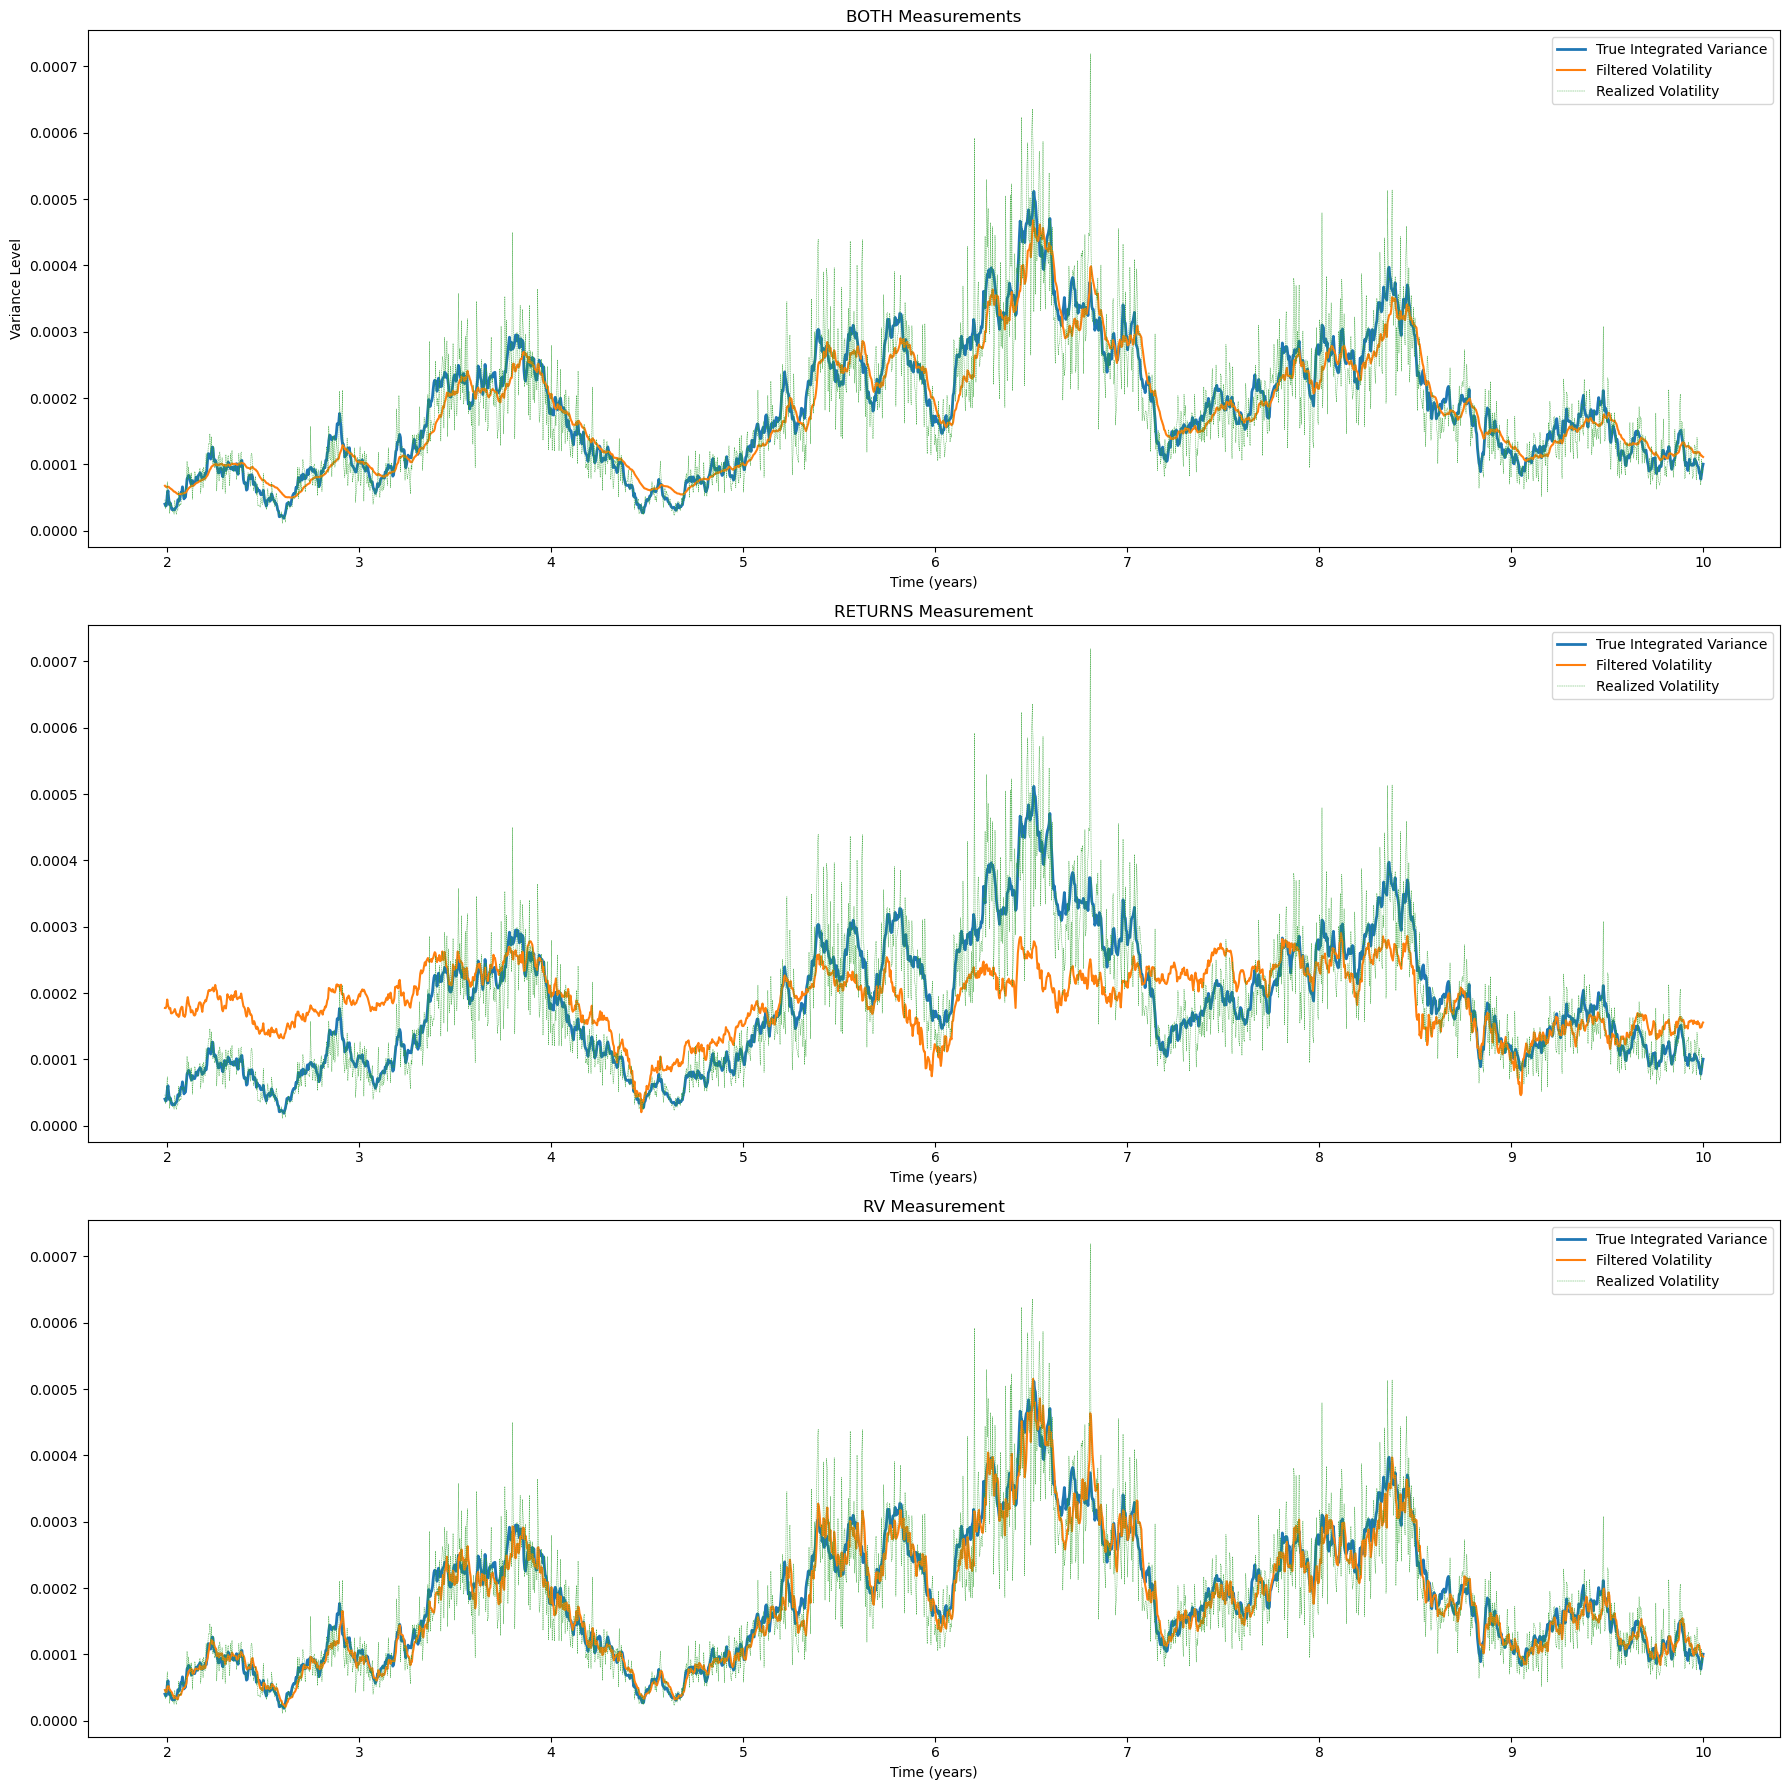

RMSE (BOTH - Filtered vs True): 0.000027
RMSE (RETURNS - Filtered vs True): 0.000071
RMSE (RV - Filtered vs True): 0.000021

--- Model Summary: BOTH ---

Heston Kalman Filter Summary
Measurement Type: both
Time Interval (dt): 1
Initial Variance (V0): 0.010000
Initial Covariance (P0): 0.100000

Fitted Parameters:
--------------------------------------------------
kappa: 0.003184
theta: 0.000194
xi: 0.000613
mu: 0.000097
sigma: 0.000068

Negative Log-Likelihood: -22327.333763
Convergence: True

AIC: -44644.667526
BIC: -44615.509439

--- Model Summary: RETURNS ---

Heston Kalman Filter Summary
Measurement Type: returns
Time Interval (dt): 1
Initial Variance (V0): 0.010000
Initial Covariance (P0): 0.100000

Fitted Parameters:
--------------------------------------------------
kappa: 0.005433
theta: 0.000162
xi: 0.003474
mu: 0.000439

Negative Log-Likelihood: -5845.263268
Convergence: True

AIC: -11682.526536
BIC: -11659.200067

--- Model Summary: RV ---

Heston Kalman Filter Summary
Measur

In [38]:
# ============================================================================
# Plotting the Filtering Results Side-by-Side
# ============================================================================
burnin = 500

fig, axes = plt.subplots(3, 1, figsize=(18, 18))

# Subplot for BOTH measurements
axes[0].plot(time_daily[burnin:], daily_true_V[burnin:], label="True Integrated Variance", lw=2)
axes[0].plot(time_daily[burnin:], V_filt_both[burnin:], label="Filtered Volatility", lw=1.5)
axes[0].plot(time_daily[burnin:], daily_RV[burnin:], label="Realized Volatility", lw=0.3, linestyle="--")
axes[0].set_title("BOTH Measurements")
axes[0].set_xlabel("Time (years)")
axes[0].set_ylabel("Variance Level")
axes[0].legend(loc="upper right")

# Subplot for RETURNS measurement
axes[1].plot(time_daily[burnin:], daily_true_V[burnin:], label="True Integrated Variance", lw=2)
axes[1].plot(time_daily[burnin:], V_filt_returns[burnin:], label="Filtered Volatility", lw=1.5)
axes[1].plot(time_daily[burnin:], daily_RV[burnin:], label="Realized Volatility", lw=0.3, linestyle="--")
axes[1].set_title("RETURNS Measurement")
axes[1].set_xlabel("Time (years)")
axes[1].legend(loc="upper right")

# Subplot for RV measurement
axes[2].plot(time_daily[burnin:], daily_true_V[burnin:], label="True Integrated Variance", lw=2)
axes[2].plot(time_daily[burnin:], V_filt_rv[burnin:], label="Filtered Volatility", lw=1.5)
axes[2].plot(time_daily[burnin:], daily_RV[burnin:], label="Realized Volatility", lw=0.3, linestyle="--")
axes[2].set_title("RV Measurement")
axes[2].set_xlabel("Time (years)")
axes[2].legend(loc="upper right")

plt.tight_layout()
plt.show()

# ============================================================================
# Compute RMSE (Post Burnin)
# ============================================================================

true_post = daily_true_V[burnin:]
rmse_both = np.sqrt(np.mean((true_post - V_filt_both[burnin:]) ** 2))
rmse_returns = np.sqrt(np.mean((true_post - V_filt_returns[burnin:]) ** 2))
rmse_rv = np.sqrt(np.mean((true_post - V_filt_rv[burnin:]) ** 2))

print(f"RMSE (BOTH - Filtered vs True): {rmse_both:.6f}")
print(f"RMSE (RETURNS - Filtered vs True): {rmse_returns:.6f}")
print(f"RMSE (RV - Filtered vs True): {rmse_rv:.6f}")

# ============================================================================
# Print Model Summaries for Each Measurement Type
# ============================================================================

print("\n--- Model Summary: BOTH ---")
hkf_both.summary()

print("\n--- Model Summary: RETURNS ---")
hkf_returns.summary()

print("\n--- Model Summary: RV ---")
hkf_rv.summary()